In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install kneed
from kneed import KneeLocator
import seaborn as sns

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

In [371]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv"
df = pd.read_csv(url)
df.head()

,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


In [372]:
# describe data
df.describe()

,Population,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
count,2.250000e+02,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000
mean,3.507321e+07,2.184781e+06,2.744813e+04,136900.373333,1096.715556,1.444125
std,1.392418e+08,7.275938e+06,9.689177e+04,145060.340289,1195.715543,1.741728
min,8.050000e+02,1.000000e+00,0.000000e+00,9.000000,0.000000,0.000000
25%,5.665570e+05,2.407100e+04,1.890000e+02,11384.000000,123.000000,0.511291
50%,5.827911e+06,1.639360e+05,1.965000e+03,88987.000000,708.000000,1.036905
75%,2.190585e+07,1.092547e+06,1.366000e+04,223335.000000,1795.000000,1.977017
max,1.439324e+09,8.183905e+07,1.008222e+06,696044.000000,6286.000000,18.151787


In [373]:
# Check for info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  225 non-null    object 
 1   Other names              224 non-null    object 
 2   ISO 3166-1 alpha-3 CODE  225 non-null    object 
 3   Population               225 non-null    int64  
 4   Continent                225 non-null    object 
 5   Total Cases              225 non-null    int64  
 6   Total Deaths             225 non-null    int64  
 7   Tot Cases//1M pop        225 non-null    int64  
 8   Tot Deaths/1M pop        225 non-null    int64  
 9   Death percentage         225 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 17.7+ KB


In [374]:
# drop customer id
df = df.drop('Other names', axis=1)

In [375]:
print(df.columns.tolist())


['Country', 'ISO 3166-1 alpha-3 CODE', 'Population', 'Continent', 'Total Cases', 'Total Deaths', 'Tot\xa0Cases//1M pop', 'Tot\xa0Deaths/1M pop', 'Death percentage']


In [376]:
# rename the Annual Income (k$)	Spending Score (1-100) column
df = df.rename(columns={"Tot\xa0Cases//1M pop": "Tot Cases/1M pop", "Tot\xa0Deaths/1M pop": "Tot Deaths/1M pop"})
df.head()

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


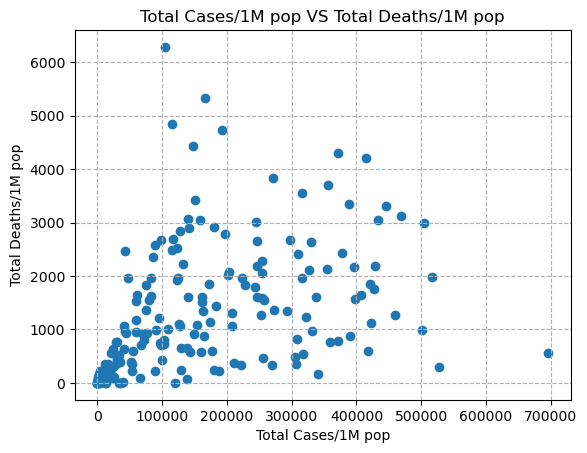

In [377]:
plt.scatter(df['Tot Cases/1M pop'], df['Tot Deaths/1M pop'])
plt.title('Total Cases/1M pop VS Total Deaths/1M pop')
plt.xlabel('Total Cases/1M pop')
plt.ylabel('Total Deaths/1M pop')
plt.grid(axis='both', linestyle='--')
plt.show()

secara umum, menunjukkan korelasi positif yang lemah hingga sedang. Ini berarti bahwa wilayah yang memiliki Total Kasus yang lebih tinggi per 1 Juta Populasi cenderung memiliki Total Kematian yang lebih tinggi per 1 Juta Populasi. Jadi, total death meningkat seiring total case meningkat. Namun tetap ada outlier, seperti total cases 700.000 (sangat tinggi) namun yang death hanya kurang dari 1000. 

In [378]:
import plotly.express as px

fig = px.choropleth(
    df,
    locations = "ISO 3166-1 alpha-3 CODE",
    color = "Continent",
    hover_name = "Country",
    projection = "natural earth",
    title= "World Map of Countries by Continent"
)

fig.show()

peta diatas menggunakan enam kategori warna yang mewakili setiap benua. Dengan tujuan mengetahui persebaran data dalam dataset covid-19 yang akan di teliti

In [379]:
cat_cols = ['Country', 'ISO 3166-1 alpha-3 CODE',
            'Continent']

# Buat dictionary untuk menyimpan encoder tiap kolom
encoders = {}

# Loop untuk encoding tiap kolom kategorikal
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # simpan encoder ke dictionary

# Cek hasil
df.head()

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage
0,0,1,40462186,1,177827,7671,4395,190,4.313743
1,1,4,2872296,2,273870,3492,95349,1216,1.275058
2,2,57,45236699,0,265691,6874,5873,152,2.587216
3,3,5,77481,2,40024,153,516565,1975,0.382271
4,4,2,34654212,0,99194,1900,2862,55,1.915438


In [380]:
# INI DIGABUNGIN YG SAMA"
with open("label_encoder_mapping.txt", "w", encoding="utf-8") as f:
    for col, le in encoders.items():
        f.write(f"\nMapping kolom: {col}\n")
        for i, cls in enumerate(le.classes_):
            f.write(f"{i} → {cls}\n")

print("✅ Mapping disimpan ke 'label_encoder_mapping.txt'")


✅ Mapping disimpan ke 'label_encoder_mapping.txt'


In [381]:
print(df.columns.tolist())


['Country', 'ISO 3166-1 alpha-3 CODE', 'Population', 'Continent', 'Total Cases', 'Total Deaths', 'Tot Cases/1M pop', 'Tot Deaths/1M pop', 'Death percentage']


In [382]:
# # create new dataframe that consist only annual income and spending score
# df_scaled = df[['Population', 'Total Cases', 'Total Deaths', 'Tot Cases/1M pop', 'Tot Deaths/1M pop', 'Death percentage']]
# df_scaled.head()

In [383]:
# Pisahkan kolom numerik dan kategorikal
num_cols = ['Population', 'Total Cases', 'Total Deaths',
'Tot Cases/1M pop', 'Tot Deaths/1M pop', 'Death percentage']
cat_cols = [col for col in df.columns if col not in num_cols]

# Scaling hanya kolom numerik
sc = StandardScaler()
df_num_scaled = pd.DataFrame(sc.fit_transform(df[num_cols]), 
                             columns=num_cols,
                             index=df.index)

# Gabungkan kolom numerik yang sudah di-scale dengan kolom kategorikal
df_sc_scaled = pd.concat([df_num_scaled, df[cat_cols]], axis=1)

# Cek hasil
df_sc_scaled.head()


,Population,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage,Country,ISO 3166-1 alpha-3 CODE,Continent
0,0.038789,-0.276449,-0.204571,-0.915487,-0.759994,1.651243,0,1,1
1,-0.231774,-0.263220,-0.247798,-0.287081,0.099982,-0.097285,1,4,2
2,0.073154,-0.264347,-0.212815,-0.905275,-0.791845,0.657760,2,57,0
3,-0.251891,-0.295431,-0.282336,2.623123,0.736164,-0.611015,3,5,2
4,-0.003016,-0.287281,-0.264265,-0.926078,-0.873149,0.271204,4,2,0


# K-MEANS

In [384]:
from sklearn.cluster import KMeans

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

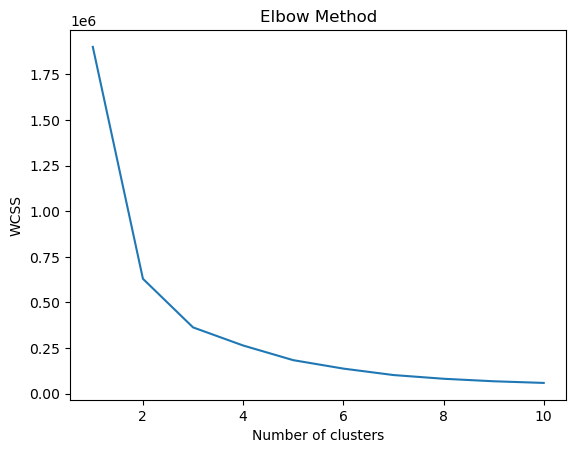

In [385]:
wcss = []
for i in range(1, 11):   #clusters 1-10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_sc_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [386]:
# Create a DataFrame to display the WCSS values for each number of clusters
wcss_table = pd.DataFrame({
    "Number of Clusters": range(1, 11),
    "WCSS": wcss
})

# Display the table
print(wcss_table)

   Number of Clusters          WCSS
0                   1  1.900238e+06
1                   2  6.299552e+05
2                   3  3.636483e+05
3                   4  2.643608e+05
4                   5  1.840485e+05
5                   6  1.377697e+05
6                   7  1.024862e+05
7                   8  8.210710e+04
8                   9  6.835129e+04
9                  10  5.931073e+04


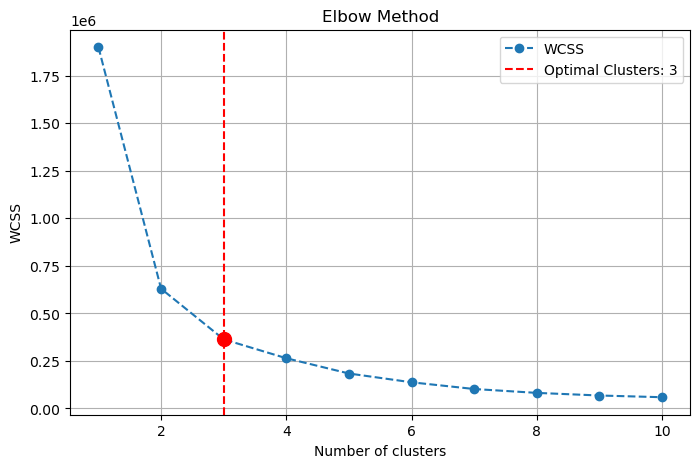

The optimal number of clusters is: 3


In [387]:
# Example WCSS values and cluster numbers
clusters = range(1, 11)

# Automatically find the elbow point using the KneeLocator
knee_locator = KneeLocator(clusters, wcss, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(clusters, wcss, marker='o', linestyle='--', label="WCSS")
plt.axvline(optimal_clusters, linestyle='--', color='red', label=f'Optimal Clusters: {optimal_clusters}')
plt.scatter(optimal_clusters, wcss[optimal_clusters-1], c='red', s=100, zorder=5)  # Highlight elbow point
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_clusters}")

In [388]:
df_kmeans = df.copy()
df_kmeans

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage
0,0,1,40462186,1,177827,7671,4395,190,4.313743
1,1,4,2872296,2,273870,3492,95349,1216,1.275058
2,2,57,45236699,0,265691,6874,5873,152,2.587216
3,3,5,77481,2,40024,153,516565,1975,0.382271
4,4,2,34654212,0,99194,1900,2862,55,1.915438
...,...,...,...,...,...,...,...,...,...
220,220,219,10894,5,454,7,41674,643,1.541850
221,221,61,623031,0,10,1,16,2,10.000000
222,222,221,30975258,1,11806,2143,381,69,18.151787
223,223,223,19284482,0,317076,3967,16442,206,1.251120


In [389]:
# Fit K-Means to the data with the optimal number of K cluster = 6
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0)
clusters = kmeans.fit_predict(df_sc_scaled)

# Add the cluster labels to the DataFrame
df_kmeans['KMeans_Cluster'] = clusters

# Show the df
df_kmeans.head()

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage,KMeans_Cluster
0,0,1,40462186,1,177827,7671,4395,190,4.313743,1
1,1,4,2872296,2,273870,3492,95349,1216,1.275058,1
2,2,57,45236699,0,265691,6874,5873,152,2.587216,1
3,3,5,77481,2,40024,153,516565,1975,0.382271,1
4,4,2,34654212,0,99194,1900,2862,55,1.915438,1


In [397]:
score = silhouette_score(df_sc_scaled, clusters)
print("Silhouette Score:", score)

Silhouette Score: 0.5071395644674189


In [391]:
df_kmeans['ISO 3166-1 alpha-3 CODE'] = encoders['ISO 3166-1 alpha-3 CODE'].inverse_transform(df_kmeans['ISO 3166-1 alpha-3 CODE'])
df_kmeans['Country'] = encoders['Country'].inverse_transform(df_kmeans['Country'])
df_kmeans['Continent'] = encoders['Continent'].inverse_transform(df_kmeans['Continent'])

In [392]:
df_kmeans

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage,KMeans_Cluster
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743,1
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058,1
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216,1
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271,1
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438,1
...,...,...,...,...,...,...,...,...,...,...
220,Wallis and Futuna,WLF,10894,Oceania,454,7,41674,643,1.541850,2
221,Western Sahara,ESHÂ,623031,Africa,10,1,16,2,10.000000,0
222,Yemen,YEM,30975258,Asia,11806,2143,381,69,18.151787,2
223,Zambia,ZMB,19284482,Africa,317076,3967,16442,206,1.251120,2


In [393]:
import plotly.express as px

fig = px.choropleth(
    df_kmeans,
    locations = "ISO 3166-1 alpha-3 CODE",
    color = "KMeans_Cluster",
    hover_name = "Country",
    projection = "natural earth",
    title= "World Map of Countries by Continent"
)

fig.show()

Setela dilakukan cluster menggunakan k-means, tebentuk 3 cluster, sehingga peta diatas menunjukan sebaran benua dan country berdasarkan cluster yang sudah terbentuk

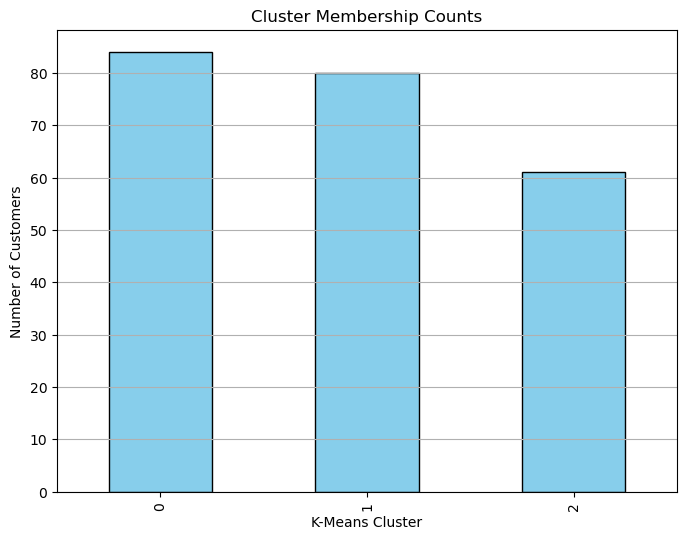

In [394]:
cluster_counts = df_kmeans['KMeans_Cluster'].value_counts()

plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Membership Counts')
plt.xlabel('K-Means Cluster')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.show()


In [395]:
print(df_kmeans.columns.tolist())


['Country', 'ISO 3166-1 alpha-3 CODE', 'Population', 'Continent', 'Total Cases', 'Total Deaths', 'Tot Cases/1M pop', 'Tot Deaths/1M pop', 'Death percentage', 'KMeans_Cluster']


In [398]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df_kmeans.groupby(clusters).agg({'Country': ['first', 'count'],
                                            'ISO 3166-1 alpha-3 CODE': ['first', 'count'],
                                            'Population': ['mean', 'min', 'max'],
                                            'Continent': ['first', 'count'],
                                            'Total Cases': ['mean', 'min', 'max'],
                                            'Total Deaths': ['mean', 'min', 'max'],
                                            'Tot Cases/1M pop': ['mean', 'min', 'max'],
                                            'Tot Deaths/1M pop': ['mean', 'min', 'max'],
                                            'Death percentage': ['mean', 'min', 'max']
                                            })
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', None)

cluster_summary = cluster_summary.rename_axis('KMeans_cluster')

cluster_summary

Country       ISO 3166-1 alpha-3 CODE        \
                                 first count                   first count   
KMeans_cluster                                                               
0               British Virgin Islands    84                     VGB    84   
1                          Afghanistan    80                     AFG    80   
2                                Palau    61                     PLW    61   

                  Population                    \
                        mean   min         max   
KMeans_cluster                                   
0               3.998732e+07  1645  1403754381   
1               3.685908e+07  3657  1439323776   
2               2.596411e+07   805   334400597   

                                      Continent         Total Cases       \
                                          first count          mean  min   
KMeans_cluster                                                             
0               Latin America and the Caribbean    84  2.116873e+06    1   
1                                          Asia    80  1.765040e+06  123   
2                                       Oceania    61  2.828776e+06    2   

                          Total Deaths              Tot Cases/1M pop       \
                     max          mean min      max             mean  min   
KMeans_cluster                                                              
0               43029044  24311.654762   0   521388    134772.904762    9   
1               29999816  21549.937500   0   660269    159142.387500  108   
2               81839052  39502.540984   0  1008222    110660.147541  327   

                       Tot Deaths/1M pop           Death percentage       \
                   max              mean min   max             mean  min   
KMeans_cluster                                                             
0               526860       1019.797619   0  4732         1.416189  0.0   
1               696044       1189.625000   0  5333         1.221447  0.0   
2               468344       1080.786885   0  6286         1.774631  0.0   

                           
                      max  
KMeans_cluster             
0               10.000000  
1                4.832523  
2               18.151787

Cluster 0 – British Virgin Islands
Cluster ini berisi negara-negara berpopulasi kecil hingga menengah, namun memiliki kasus dan kematian per 1 juta penduduk yang cukup tinggi. Dampak COVID secara proporsional terlihat signifikan, meskipun angka absolutnya tidak terlalu besar. Persentase kematian (death percentage) juga berada pada level moderat. Secara umum, cluster ini menunjukkan negara kecil yang lebih rentan secara rasio terhadap populasi.

Cluster 1 – Afghanistan
Cluster ini didominasi negara berpopulasi besar, tetapi rasio kasus dan kematian per 1 juta penduduk lebih rendah dibanding cluster lain. Ini menunjukkan penyebaran COVID yang lebih terkendali secara proporsional terhadap jumlah penduduk. Death percentage juga relatif rendah. Secara keseluruhan, cluster ini mewakili negara besar dengan impact COVID yang lebih ringan secara proporsional.

Cluster 2 – Palau
Cluster ini berisi negara-negara kecil dengan rasio kasus per 1 juta penduduk tertinggi di antara semua klaster. Meskipun populasinya kecil, penyebaran COVID sangat intens secara proporsional. Tingkat kematian per 1 juta penduduk dan death percentage juga relatif tinggi. Cluster ini menunjukkan negara kecil yang mengalami dampak COVID paling berat secara rasio terhadap populasi.

# HIERARCHICAL AGGLO

silhouette score

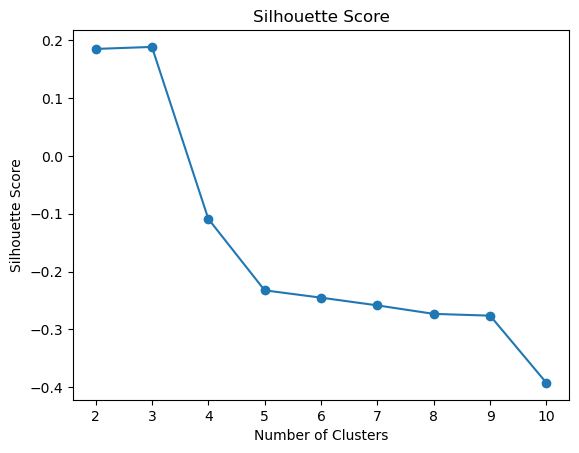

In [ ]:
# this is way to show only 1 sillhouette score
from sklearn.metrics import silhouette_score

silhouette_scores = []

for i in range(2, 11):
    # Create a new AgglomerativeClustering instance for each number of clusters
    agglo_model = AgglomerativeClustering(n_clusters=i, linkage='single')
    cluster_labels = agglo_model.fit_predict(df_sc_scaled)
    silhouette_avg = silhouette_score(df_sc_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Score = the higher the better
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

Skipping Ward linkage with Manhattan metric (not supported).


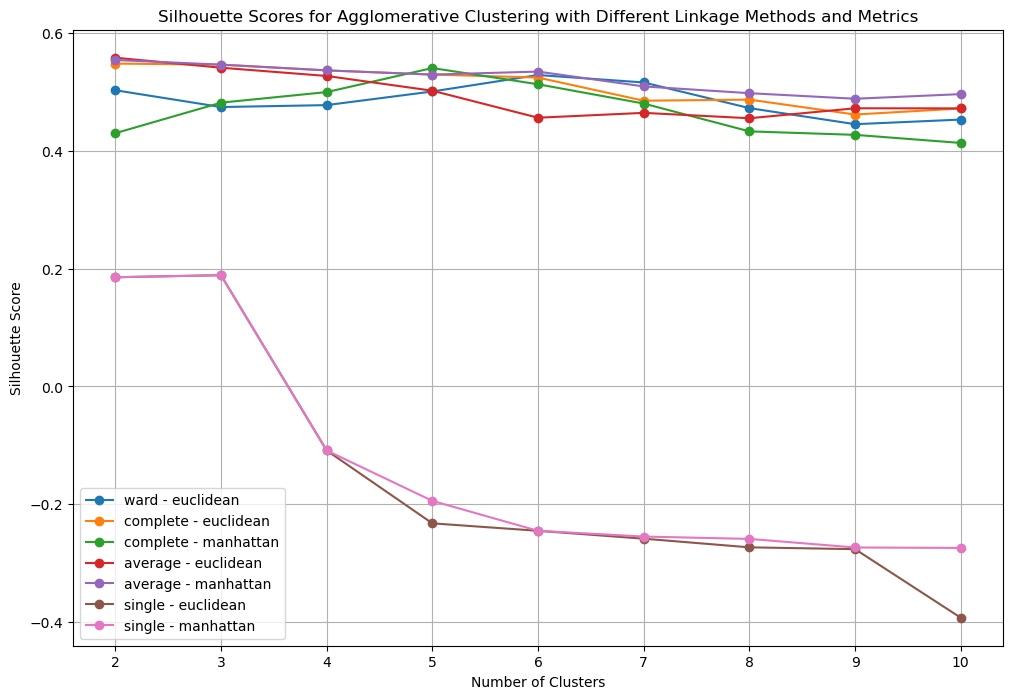

Best Silhouette Score: 0.5581735054415853
Optimal Number of Clusters: 2
Optimal Linkage Method: average
Optimal Metric: euclidean


In [400]:
# Define the range of clusters to test and linkage methods
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = 0
best_linkage = ''
best_metric = ''

results_for_plotting = []

for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip 'ward' linkage with 'manhattan' metric as it's not supported
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(df_sc_scaled)
            silhouette_avg = silhouette_score(df_sc_scaled, y_agglo)
            current_scores.append(silhouette_avg)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

# Plot the silhouette scores for each linkage method and metric combination
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering with Different Linkage Methods and Metrics")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

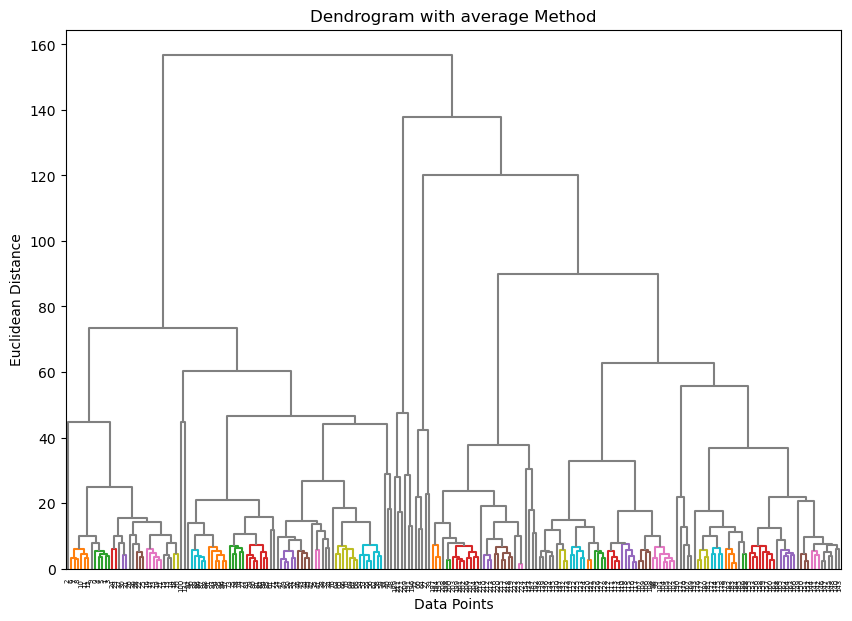

In [401]:
# Ward Method
linked = linkage(df_sc_scaled, method='average', metric='euclidean')

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked, above_threshold_color="grey", color_threshold=7.5)
plt.title("Dendrogram with average Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

In [402]:
# Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage, metric=best_metric)
y_hc = agglo.fit_predict(df_sc_scaled)

In [403]:
# Evaluation
ss = silhouette_score(df_sc_scaled, y_hc)
print(ss)

0.5581735054415853


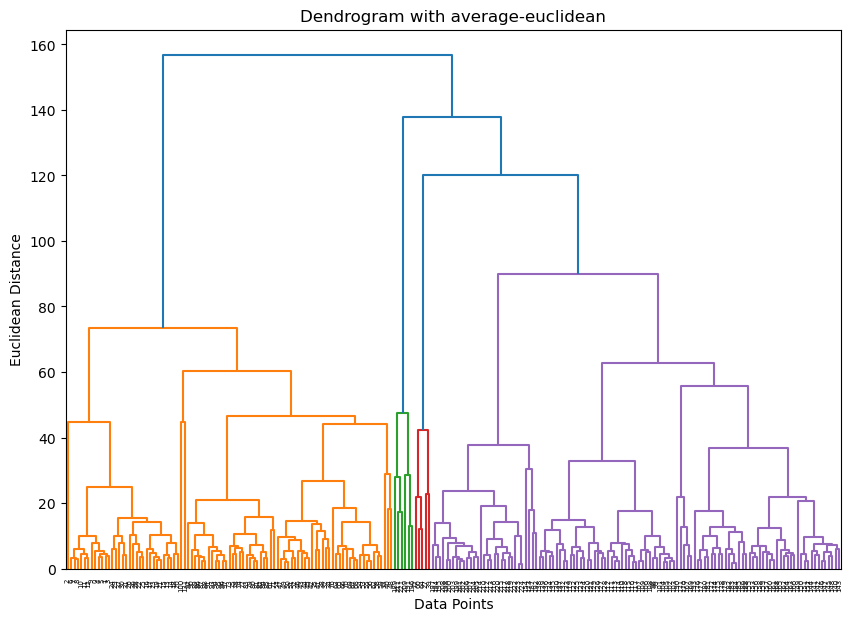

In [404]:
# Average Distance
linked = linkage(df_sc_scaled, method=best_linkage, metric=best_metric)

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with " + best_linkage + "-" + best_metric)
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

In [405]:
df_agglo = df.copy()
df_agglo

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage
0,0,1,40462186,1,177827,7671,4395,190,4.313743
1,1,4,2872296,2,273870,3492,95349,1216,1.275058
2,2,57,45236699,0,265691,6874,5873,152,2.587216
3,3,5,77481,2,40024,153,516565,1975,0.382271
4,4,2,34654212,0,99194,1900,2862,55,1.915438
...,...,...,...,...,...,...,...,...,...
220,220,219,10894,5,454,7,41674,643,1.541850
221,221,61,623031,0,10,1,16,2,10.000000
222,222,221,30975258,1,11806,2143,381,69,18.151787
223,223,223,19284482,0,317076,3967,16442,206,1.251120


In [406]:
df_agglo['ISO 3166-1 alpha-3 CODE'] = encoders['ISO 3166-1 alpha-3 CODE'].inverse_transform(df_agglo['ISO 3166-1 alpha-3 CODE'])
df_agglo['Country'] = encoders['Country'].inverse_transform(df_agglo['Country'])
df_agglo['Continent'] = encoders['Continent'].inverse_transform(df_agglo['Continent'])

In [407]:
df_agglo

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438
...,...,...,...,...,...,...,...,...,...
220,Wallis and Futuna,WLF,10894,Oceania,454,7,41674,643,1.541850
221,Western Sahara,ESHÂ,623031,Africa,10,1,16,2,10.000000
222,Yemen,YEM,30975258,Asia,11806,2143,381,69,18.151787
223,Zambia,ZMB,19284482,Africa,317076,3967,16442,206,1.251120


In [408]:
# Add the cluster labels to the original data
df_agglo['Agglo'] = y_hc

# Analyze the clusters with the original values
df_agglo.head()

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases/1M pop,Tot Deaths/1M pop,Death percentage,Agglo
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743,1
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058,1
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216,1
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271,1
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438,1


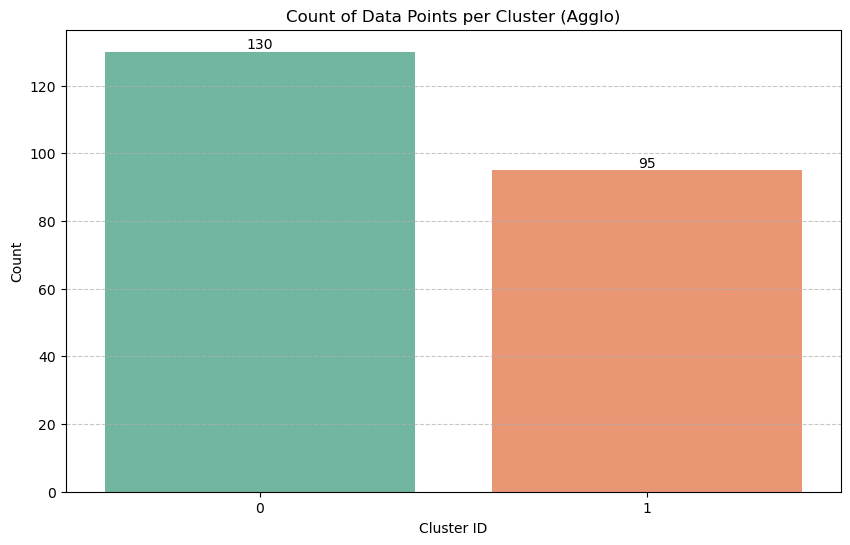

In [409]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each cluster in the 'Agglo' column of df
cluster_counts = df_agglo['Agglo'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='Set2', legend=False)

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.title('Count of Data Points per Cluster (Agglo)')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [410]:
import plotly.express as px

fig = px.choropleth(
    df_agglo,
    locations = "ISO 3166-1 alpha-3 CODE",
    color = "Agglo",
    hover_name = "Country",
    projection = "natural earth",
    title= "World Map of Countries by Continent"
)

fig.show()

setelah melakukan modeling menggunakan hierarchical agglo, terbentuk 2 cluster. Peta diatas menunjukan sebaran country dan benua berdasarkan cluster yang telah terbentuk

In [411]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df_agglo.groupby(y_hc).agg({'Country': ['first', 'count'],
                                              'ISO 3166-1 alpha-3 CODE': ['first', 'count'],
                                              'Population': ['mean', 'min', 'max'],
                                              'Continent': ['first', 'count'],
                                              'Total Cases': ['mean', 'min', 'max'],
                                              'Total Deaths': ['mean', 'min', 'max'],
                                              'Tot Cases/1M pop': ['mean', 'min', 'max'],
                                              'Tot Deaths/1M pop': ['mean', 'min', 'max'],
                                              'Death percentage': ['mean', 'min', 'max']
})

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', None)

# Rename the <lambda> column in the Gender MultiIndex level
cluster_summary = cluster_summary.rename(columns={'first': 'mode'}, level=1)

cluster_summary = cluster_summary.rename_axis('cluster')

cluster_summary

Country       ISO 3166-1 alpha-3 CODE        \
                           mode count                    mode count   
cluster                                                               
0        British Virgin Islands   130                     VGB   130   
1                   Afghanistan    95                     AFG    95   

           Population                                          Continent  \
                 mean   min         max                             mode   
cluster                                                                    
0        2.359047e+07   805   334400597  Latin America and the Caribbean   
1        5.078643e+07  3657  1439323776                             Asia   

                Total Cases                Total Deaths               \
        count          mean min       max          mean min      max   
cluster                                                                
0         130  2.198268e+06   2  81839052  27066.023077   0  1008222   
1          95  2.166326e+06   1  43029044  27971.010526   0   660269   

        Tot Cases/1M pop             Tot Deaths/1M pop            \
                    mean min     max              mean min   max   
cluster                                                            
0          124694.176923  16  468344       1048.407692   0  6286   
1          153603.589474   9  696044       1162.821053   0  5333   

        Death percentage                  
                    mean  min        max  
cluster                                   
0               1.576882  0.0  18.151787  
1               1.262458  0.0   4.832523

Cluster 0 --> British Virgin Islands di continent Latin America and the Caribbean
Populasi rata-rata rendah–menengah (sekitar 23 juta).
Total kasus COVID dan total kematian rendah–sedang, tetapi kasus per 1 juta penduduk (Tot Cases/1M) dan kematian per 1 juta penduduk (Tot Deaths/1M) relatif tinggi.
Hal ini menunjukkan bahwa meski populasi tidak besar, proporsi kasus terhadap jumlah penduduk sangat tinggi.
Death percentage (persentase kematian) relatif lebih tinggi dibanding cluster 1.


Interpretasi:
→ Cluster ini mewakili negara-negara kecil hingga menengah populasi yang mengalami dampak COVID cukup signifikan secara proporsional, meskipun angka absolutnya tidak besar.

Cluster 1 --> Afghanistan di continent Asia
Populasi besar (rata-rata 50 juta).
Total kasus COVID dan total kematian rendah–sedang dalam angka absolut.
Namun Tot Cases/1M dan Tot Deaths/1M lebih rendah dibanding Cluster 0.
Death percentage cenderung lebih rendah (sekitar 1.26% vs 1.57% di cluster 0).

Interpretasi:
→ Cluster ini menggambarkan negara-negara berpopulasi besar di mana penyebaran COVID secara proporsional ke penduduk lebih kecil, sehingga rasio kasus/kematian per 1 juta penduduk lebih rendah.

Rekomendasi: model hierarchical agglo, dilihat dari silhouette score agglo lebih baik dibandingkan kmeans dengan feature" yang sama. Agglo lebih baik digunakan untuk melihat kemiripan antar continent atau country